# Bir rakamın hangi rakam olduğunun tespiti algoritması

In [1]:
#Model
import numpy as np
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X,y=mnist['data'],mnist['target']
X_train=X[:60000]
x_test= X[60000:]
y_train=y[:60000]
y_test= y[60000:]
#training data üzerinden shuffle_index
np.random.seed(1983)
shuffle_index=np.random.permutation(60000)
X_train=X_train[shuffle_index]
y_train=y_train[shuffle_index]
#Stokastik Gradyan Deseni
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=1983)
sgd_clf.fit(X_train,y_train)

C:\Python27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=1983,
       shuffle=True, tol=None, verbose=0, warm_start=False)

Bir sayıyı tahmin etmeyi deneyelim. Bu sayının matrisine bakalım

In [14]:
some_digit = X[36000]
#Bu sayı kaçmış?
y[36000]

5.0

Bu sayıyı yeni eğittiğimiz multiclass `sgd_clf` ile tahmin etmeye çalışalım. Aşağıda çıkak sayılar 1'den dokuza hangi sayının olma ihtimlai olduğunu gösteriyor. 5 nolu değer bu seri içindeki en büyük değer bu nedenle sayı 5

In [15]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[  20119.21934878, -414665.25925221, -324974.9980094 ,
        -260633.28723711, -439938.34633408,  113576.73389496,
        -724017.50758634, -342713.78339298, -733975.3271254 ,
        -689012.14999111]])

In [16]:
np.argmax(some_digit_scores)

5

In [17]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [18]:
sgd_clf.classes_[5]

5.0

# OVO Modeli

Buraya kadarli model **one versus all** yani **OvA** modeli idi. Şimdi bir de **One versus One** yani **OvO** modeli deneylim:

In [19]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

Tahmin doğru. OVO her olasılığın geri kalanları ile ilişkisi için estimator oluşturur. Bakalım:

In [20]:
len(ovo_clf.estimators_)

45

45 estimator oluşmuş. Çünkü 9*(9-1)/2=45.

# Random Forest ile OvA denemesi

In [24]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

36000'nci sıradaki sayımızı (5) tahmin et

In [25]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

% 80 olasılıkla sayı 5

Yine training data içinde cross-validation ile doğruluğa bakalım

In [27]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86242751,  0.86379319,  0.87738161])

In [29]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.9435113 ,  0.93749687,  0.93944092])

Random forest accurarcy bakımından daha güçlü. 

# SGD classifier'imizi normalizasyonla  daha güçlü hale getirelim

Modelimizi bazen eğitim datasını dönüşüterek daha güçlü hale getirebiliriz. SGD için bunu yapalım

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91066787,  0.9099955 ,  0.90853628])

In [34]:
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.94356129,  0.93764688,  0.9393409 ])

SGD classifier'de bariz güçlenme var.

# Performans tespitinde Confusion Matrix yerine HeatMap kullanımı

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5729,    3,   22,    9,   13,   49,   47,    8,   40,    3],
       [   2, 6479,   43,   25,    7,   47,    6,   11,  110,   12],
       [  57,   38, 5331,   96,   79,   24,   97,   53,  163,   20],
       [  48,   41,  137, 5331,    3,  246,   37,   56,  135,   97],
       [  21,   24,   38,    9, 5365,    8,   52,   25,   86,  214],
       [  75,   41,   35,  175,   78, 4614,  110,   27,  173,   93],
       [  33,   23,   45,    2,   42,   96, 5630,    3,   43,    1],
       [  22,   18,   69,   33,   58,    8,    6, 5789,   21,  241],
       [  62,  149,   72,  144,   14,  164,   59,   27, 5022,  138],
       [  43,   28,   25,   83,  161,   40,    3,  193,   79, 5294]], dtype=int64)

Bu değerleri heatmap olarak gösterelim:

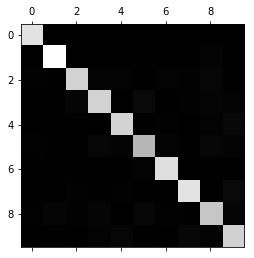

In [39]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plt.matshow(conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Beyazlar yüksek değerler, ters diyagonal beyaz bize doğru tahminlerin çok olduğunu söylüyor. 5'teki grilik algoritmanın 5'i halen karıştırdığını gösteriyor.

# Hata Oranlarını Yüzde olarak Heatmap'a yansıtmak

Bu şekilde analiz algoritmanın eksiklerini daha kolay ortaya koyacaktır. Bunun için önce normalizasyon yapıyoruz. Yani her hücre değerini satır toplamlarına böleceğiz. Sonra matrisi oluşturacağız:

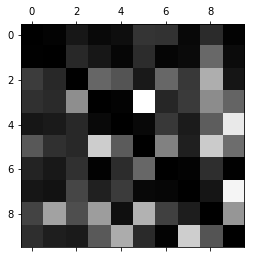

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
#norm_conf_mx = conf_mx / row_sums
norm_conf_mx=np.divide(conf_mx,row_sums,dtype="float")
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [58]:
norm_conf_mx

array([[ 0.        ,  0.0005065 ,  0.00371433,  0.0015195 ,  0.00219483,
         0.00827283,  0.00793517,  0.00135067,  0.00675333,  0.0005065 ],
       [ 0.00029665,  0.        ,  0.00637793,  0.0037081 ,  0.00103827,
         0.00697123,  0.00088994,  0.00163156,  0.01631563,  0.00177989],
       [ 0.00956697,  0.00637798,  0.        ,  0.01611279,  0.01325948,
         0.0040282 ,  0.01628063,  0.0088956 ,  0.02735817,  0.00335683],
       [ 0.00782907,  0.00668733,  0.02234546,  0.        ,  0.00048932,
         0.04012396,  0.0060349 ,  0.00913391,  0.02201925,  0.01582124],
       [ 0.00359466,  0.00410818,  0.00650462,  0.00154057,  0.        ,
         0.00136939,  0.00890106,  0.00427936,  0.01472099,  0.03663129],
       [ 0.01383509,  0.00756318,  0.00645637,  0.03228187,  0.01438849,
         0.        ,  0.02029146,  0.00498063,  0.03191293,  0.01715551],
       [ 0.00557621,  0.00388645,  0.00760392,  0.00033795,  0.00709699,
         0.0162217 ,  0.        ,  0.00050693

8 ve 9. kolonlara dikkat edin. Bu diyagramda kolonlarda parlaklık varsa ** bir çok sayının yanlışlıklar 8 veya 9 olarak sınıflandırıldığnını ** anlarız.

Aynı şekilde 8 ve9. **satırlara** bakın. Onlar da parlak. Bunun anlamı ise **8 veya 9 olan sayıların yanlşıkla başka sayılar olarak sınıflandırıldığıdır**.

3 ve 5in kesişme yeri bembeyaz. Bu ise bu iki sayının sıkça karıştırıldığını gösteriyor. Zaten şeklden bazen biz de karıştırırız.

# Üçün Beşin Hesabını Yapmak

Şimdi karışıklıkları detaylı inceleyelim. 

3 olduğu halde 3 (doğru)

3 olduğu halde 5

5 olduğu halde 3

5 olduğu halde 5 (doğru)

olarak sınıflandırılan sayıların neye benzediğine bakalım

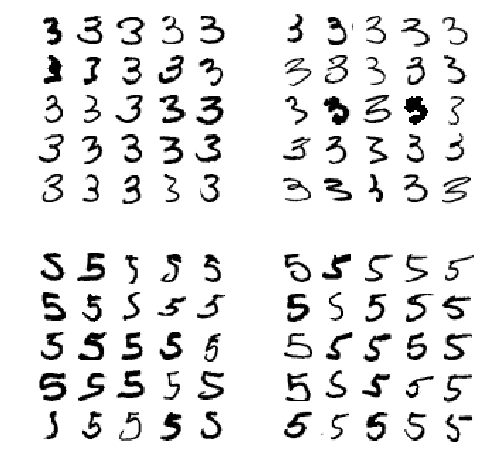

In [65]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()